In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta

In [2]:
month = 'jan'
month_num = '01'

In [3]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [4]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/GEOSChem.AerosolMass.2016*', combine = 'by_coords')

In [5]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/base_{month}_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [6]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/pulse_{month}_BC/OutputDir/HEMCO_diagnostics.2016*.nc', combine = 'by_coords')

In [7]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/2x_jan_BC/OutputDir/HEMCO_diagnostics.2016*', combine = 'by_coords')

In [8]:
height = pd.read_excel('gc_altitude.xlsx')

In [9]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds['altitude']*=1e3


In [10]:
datasets = [ds_emispulse, ds_emisbase, ds_base, ds_delta, ds_conc2x, ds_emis2x]

In [11]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

#holoview
import xarray as xr
import holoviews as hv
hv.extension('matplotlib')

ds = hv.Dataset(((ds_delta['AerMassBC']-ds_base['AerMassBC']).sum(dim = 'lev').isel(time = range(10))))
images
images = ds.to(hv.Image, ['lon', 'lat']).options( colorbar=True, cmap='pink_r')
hv.save(obj = images, filename =  'hv_anim.mp4')

Text(0.5, 1.0, '')

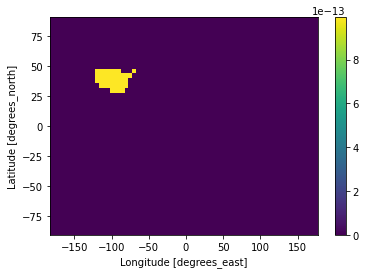

In [22]:
((ds_emispulse['EmisBCPI_Total']+ds_emispulse['EmisBCPO_Total'] )- (ds_emisbase['EmisBCPI_Total']+ds_emisbase['EmisBCPO_Total'])).isel(lev = 0, time = 0).plot()
plt.title('')

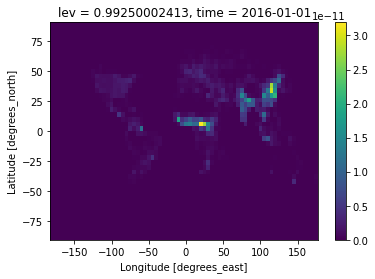

In [19]:
().isel(lev = 0, time = 0).plot()

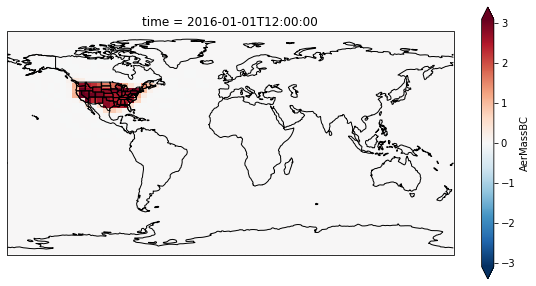

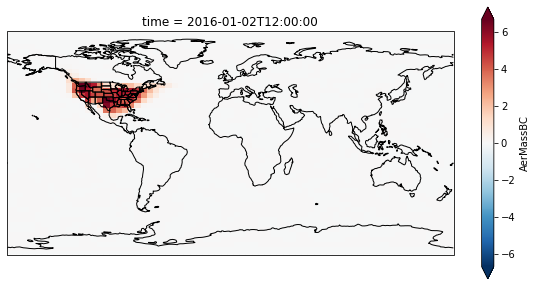

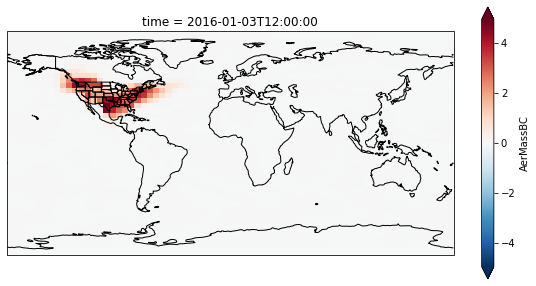

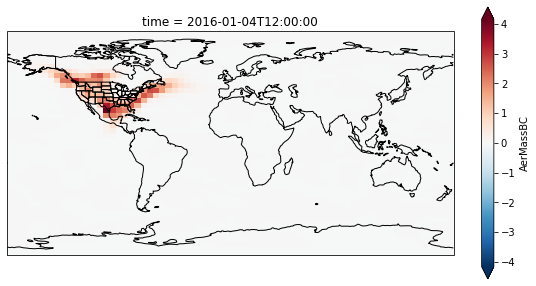

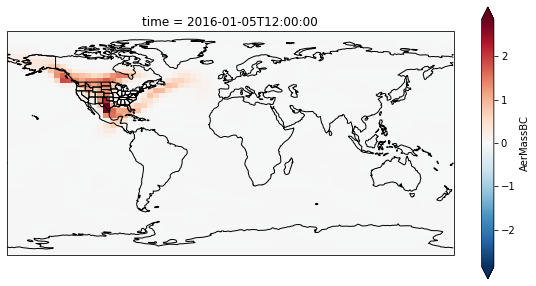

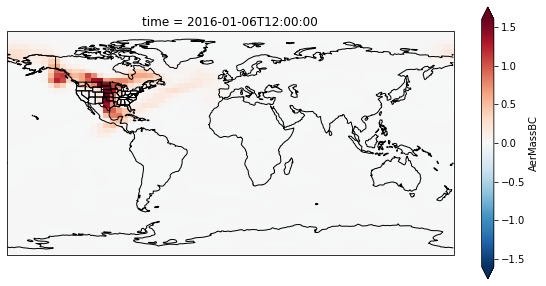

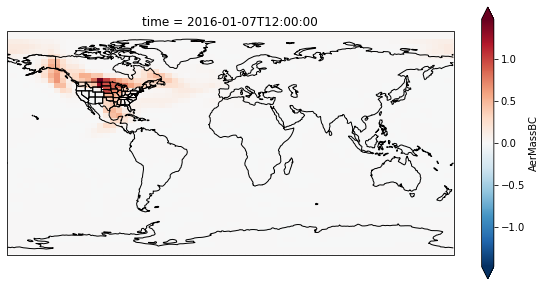

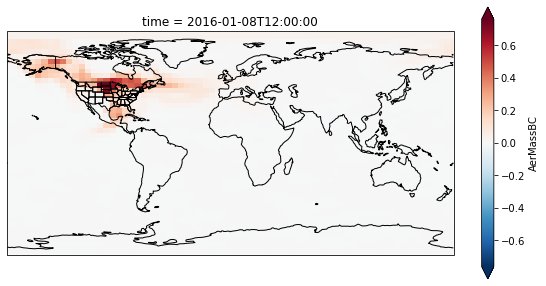

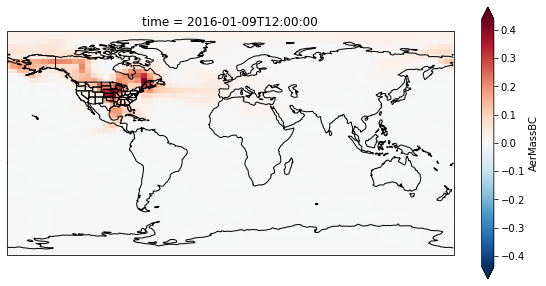

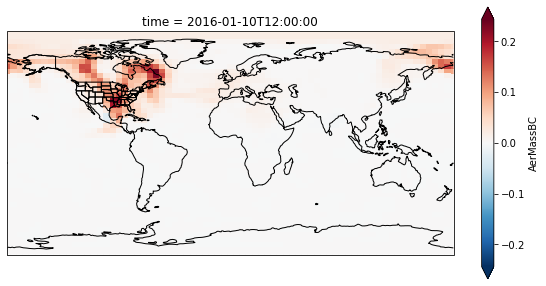

In [17]:
for t, idx in enumerate(np.arange(0,10)):
    fig,ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('b) Difference', fontsize = 16)
    ((ds_delta['AerMassBC']-ds_base['AerMassBC']).sum(dim = 'lev').isel(time = t)).plot(transform=ccrs.PlateCarree(), cmap = 'RdBu_r', extend = 'both')
    plt.savefig(f'video_images/000{idx}.png', bbox_inches = 'tight')

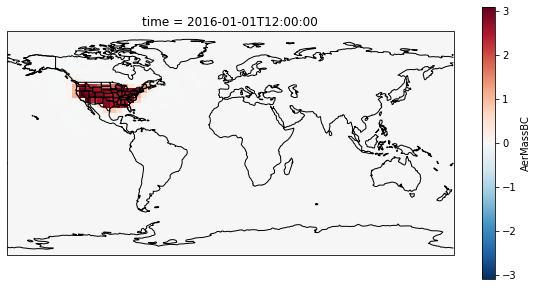

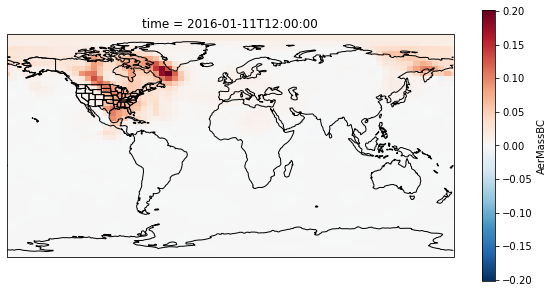

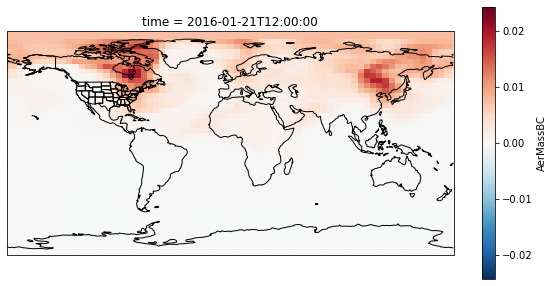

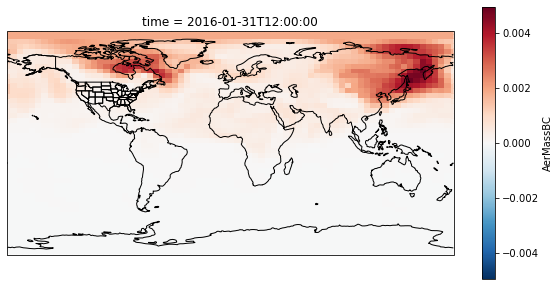

In [11]:
for t in [0,10,20,30]:
    fig,ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('b) Difference', fontsize = 16)
    ((ds_delta['AerMassBC']-ds_base['AerMassBC']).sum(dim = 'lev').isel(time = t)).plot(transform=ccrs.PlateCarree())

IndexError: Index is not smaller than dimension 45 >= 31

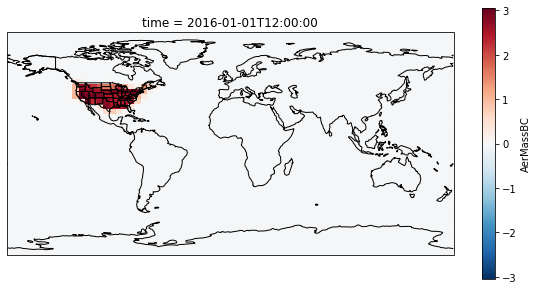

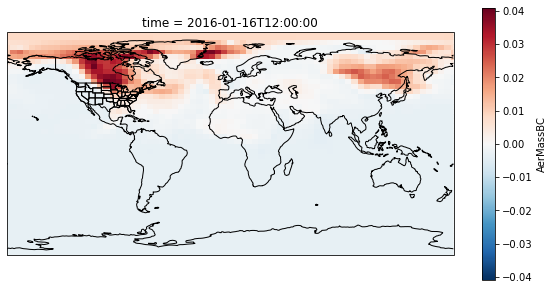

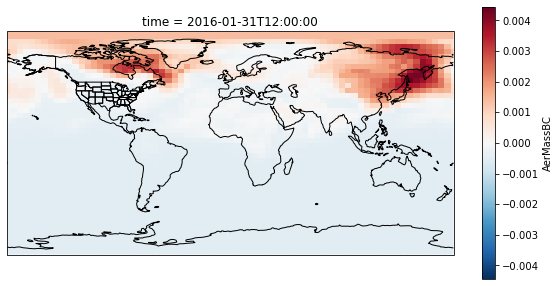

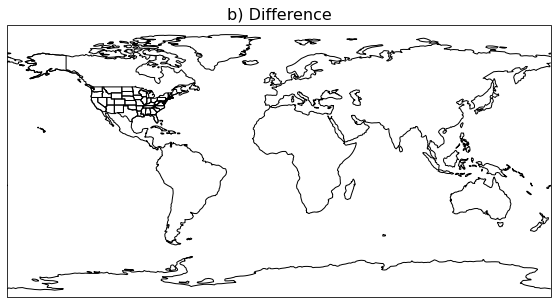

In [12]:
for t in [0,15,30,45,60]:
    fig,ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeat.STATES)
    ax.set_title('b) Difference', fontsize = 16)
    ((ds_delta['AerMassBC']-ds_base['AerMassBC']).sum(dim = 'lev')-
    (ds_delta['AerMassBC'].mean(dim = ['lat','lon'])-ds_base['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev')).isel(time = t).plot(transform=ccrs.PlateCarree())

### Global Mean

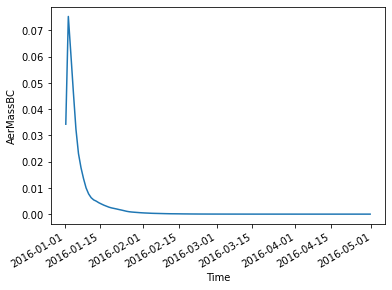

In [9]:
(ds_delta['AerMassBC'].mean(dim = ['lat','lon'])-ds_base['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev').plot()

### Global, Land Only

In [41]:
dict_base_region = {}
dict_delta_region = {}

In [42]:
#### create a mask ####
regions = regionmask.defined_regions.ar6.land

mask = regions.mask(ds_delta, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)

#### mask our population dataset ####
dict_delta_region['land_only'] = ds_delta.where(contiguous_mask)
dict_base_region['land_only'] = ds_base.where(contiguous_mask)

### AR6 Regions

In [16]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

In [43]:
#### create a mask ####
regions = regionmask.defined_regions.ar6.land

for r in ar6_coal_location:
    mask = regions.mask(ds_delta, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)

    #### mask our population dataset ####
    dict_delta_region[ar6_coal_location[r]] = ds_delta.where(contiguous_mask)
    dict_base_region[ar6_coal_location[r]] = ds_base.where(contiguous_mask)

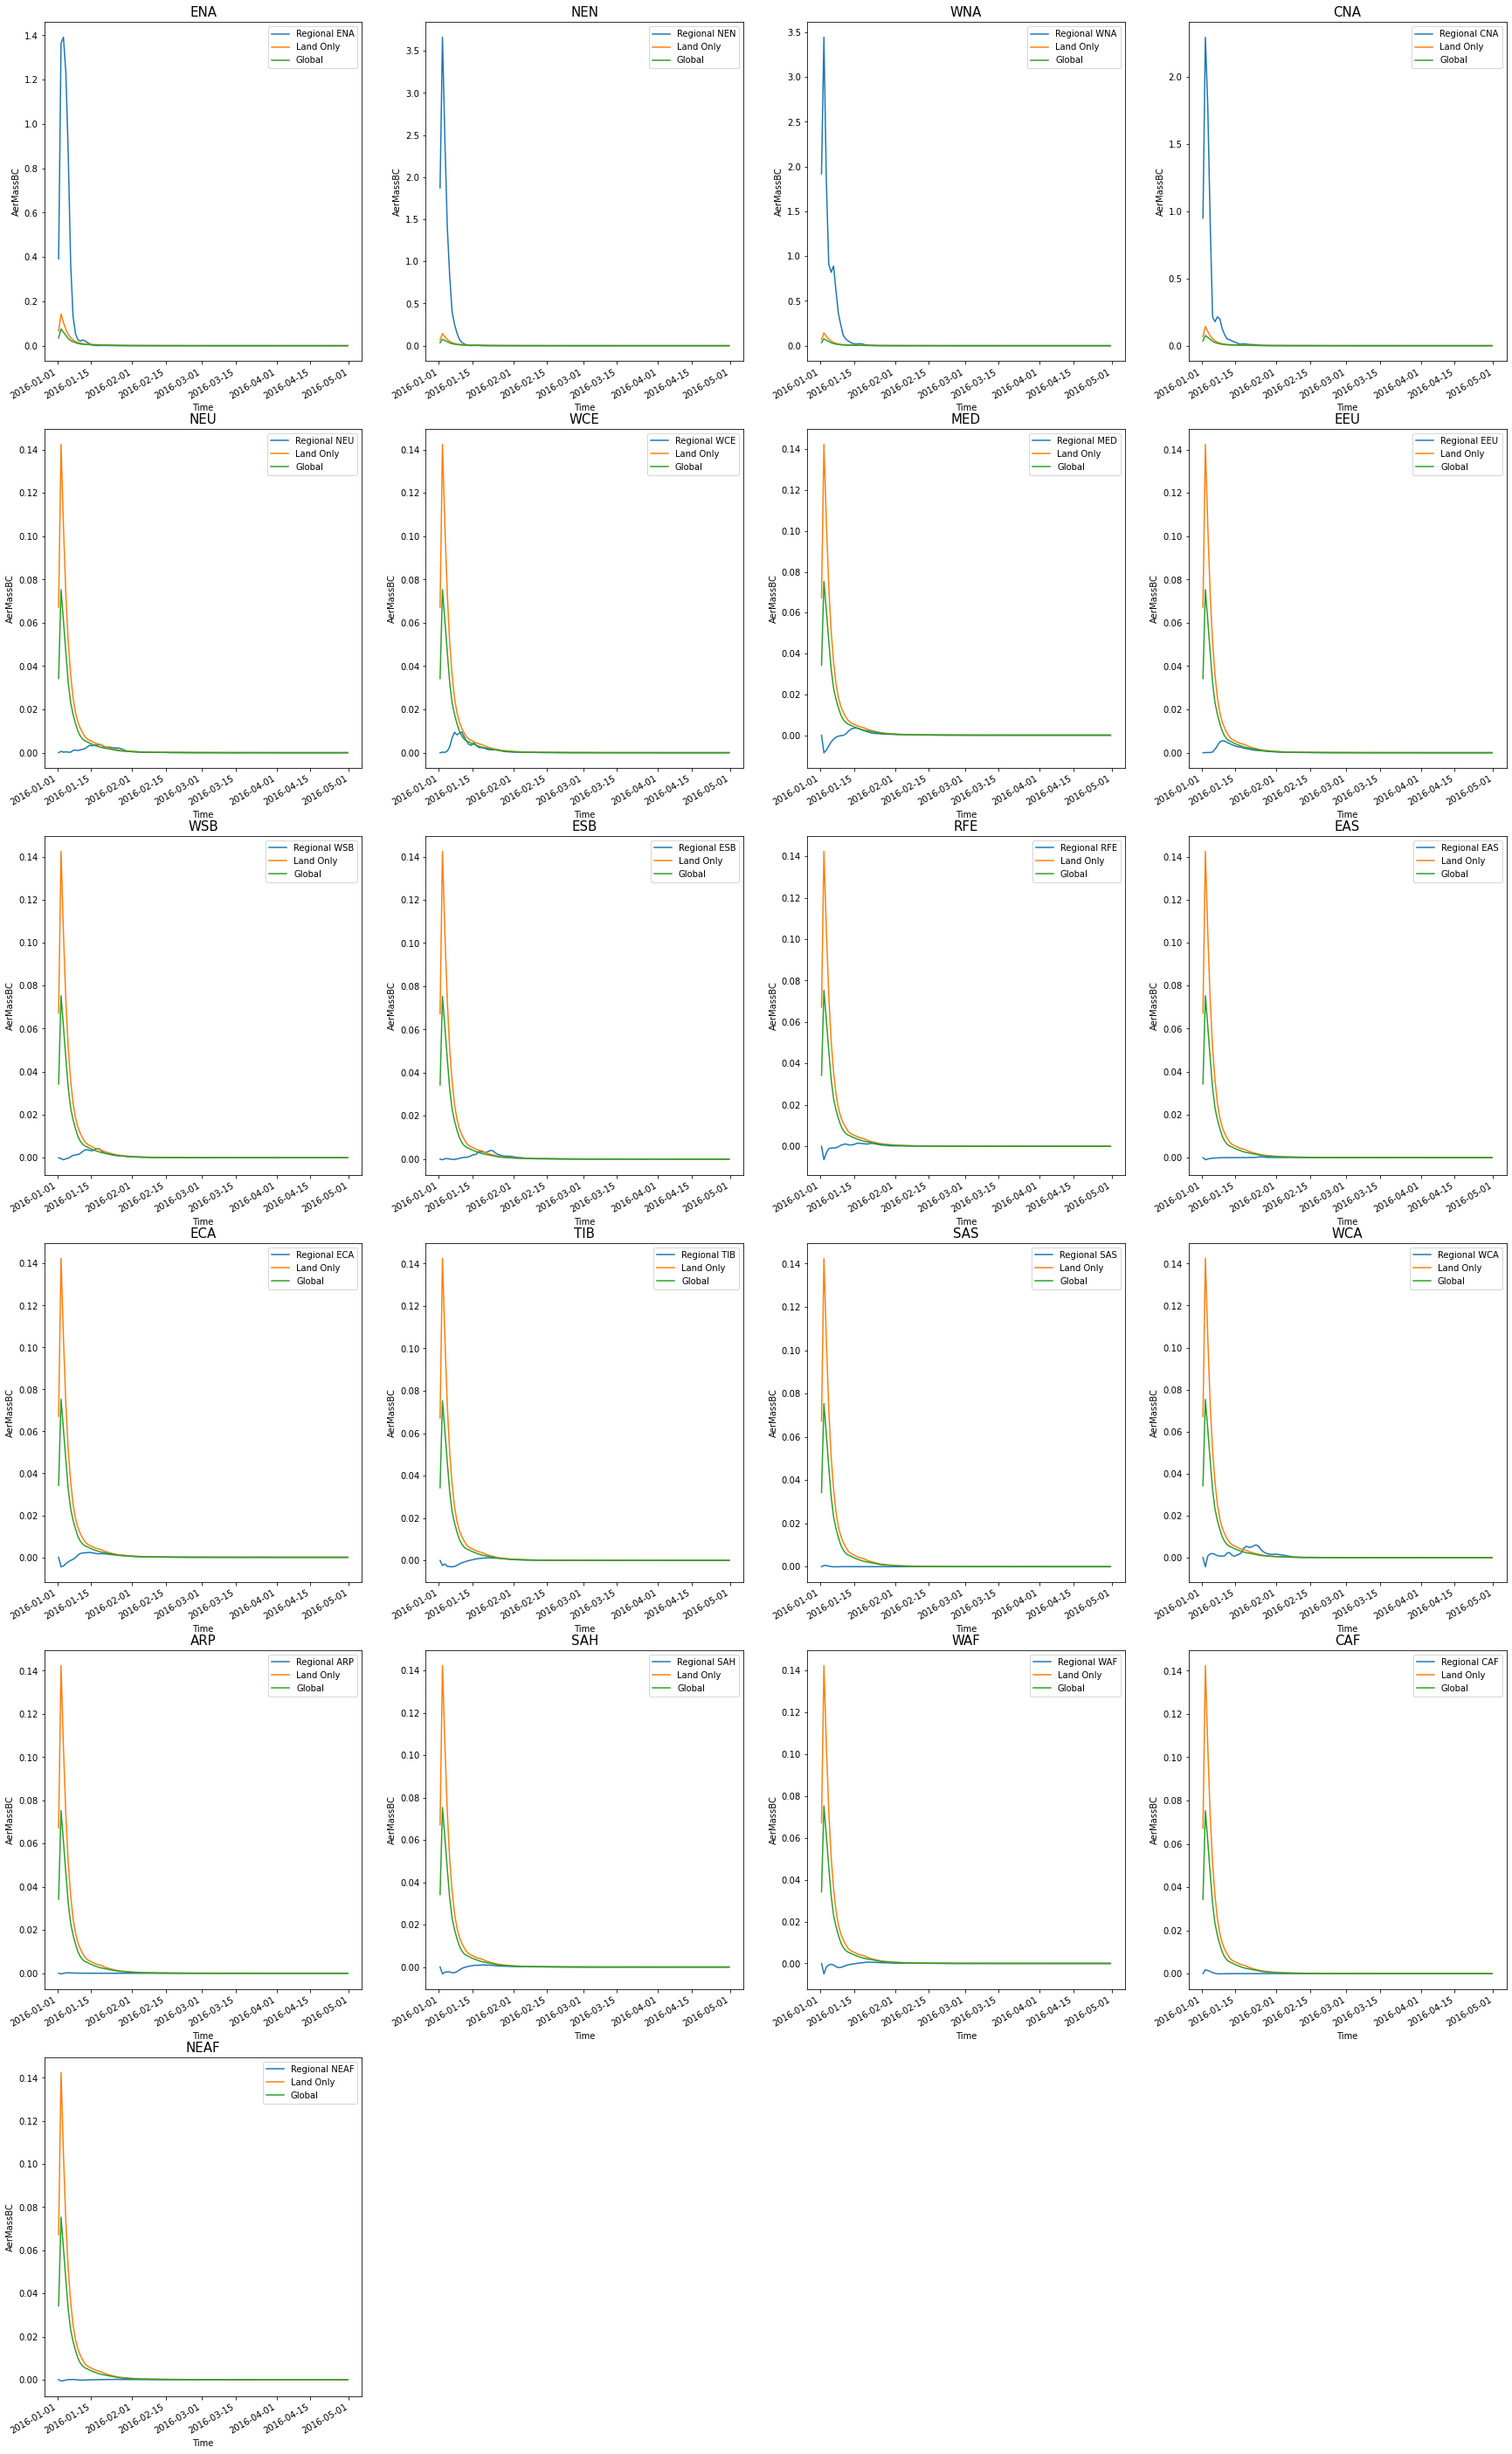

In [44]:
fig = plt.figure(figsize=(30,50))

for idx, r in enumerate(region_names.values()):
    ax = fig.add_subplot(6,4,idx+1)
    (dict_delta_region[r]['AerMassBC'].mean(dim = ['lat','lon'])-dict_base_region[r]['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev').plot(ax = ax, label = f'Regional {r}')
    (dict_delta_region['land_only']['AerMassBC'].mean(dim = ['lat','lon'])-dict_base_region['land_only']['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev').plot(ax = ax, label = f'Land Only')
    (ds_delta['AerMassBC'].mean(dim = ['lat','lon'])-ds_base['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev').plot(ax = ax, label = 'Global')
    plt.title(r, fontsize = 15)
    plt.legend()

### US Mean

In [14]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds_delta, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
ds_delta_US = ds_delta.where(contiguous_mask)
ds_base_US = ds_base.where(contiguous_mask)
ds_emisbase_US = ds_emisbase.where(contiguous_mask)
ds_emispulse_US = ds_emispulse.where(contiguous_mask)
ds_conc2x_US = ds_conc2x.where(contiguous_mask)

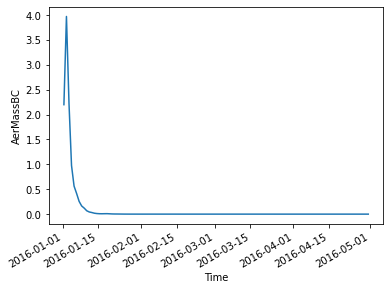

In [15]:
(ds_delta_US['AerMassBC'].mean(dim = ['lat','lon'])-ds_base_US['AerMassBC'].mean(dim = ['lat','lon'])).sum(dim = 'lev').plot()

# Global Mean

## Doubled concentration

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


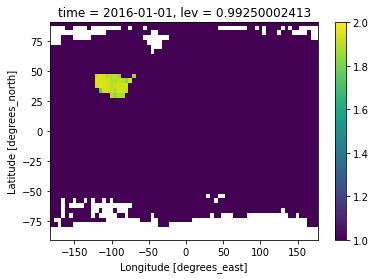

In [10]:
((ds_emis2x['EmisBCPO_Total']+ds_emis2x['EmisBCPI_Total'])/
 (ds_emisbase['EmisBCPO_Total']+ds_emisbase['EmisBCPI_Total'])).isel(time = 0, lev = 0).plot(vmax = 2)

## Recreate Doubled Concentration

1. def emisBC_total

2. def global_weighted_avg

3. clean up

4. everything in days or seconds

5. .diff(altitude) needs to be fixed to not be the total height

In [15]:
sec_day = 86400

In [16]:
#convert everything into days
ds_emisbase['EmisBCPO_Total']*=sec_day
ds_emisbase['EmisBCPI_Total']*=sec_day
ds_emispulse['EmisBCPO_Total']*=sec_day
ds_emispulse['EmisBCPI_Total']*=sec_day
ds_emis2x['EmisBCPO_Total']*=sec_day
ds_emis2x['EmisBCPI_Total']*=sec_day


In [40]:
#lat, lon, lev average

f = ((ds_emisbase['EmisBCPO_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon','lev'])+
     ds_emisbase['EmisBCPI_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon','lev'])))*2
G = (ds_delta['AerMassBC'].weighted(ds_delta['AREA']*ds_delta['altitude']).mean(dim = ['lat','lon','lev'])-
     ds_base['AerMassBC'].weighted(ds_base['AREA']*ds_base['altitude']).mean(dim = ['lat','lon','lev']))

f_0 = ((ds_emispulse['EmisBCPO_Total'].weighted(ds_emispulse['AREA']*ds_emispulse['altitude']).mean(dim = ['lat','lon','lev'])
        +ds_emispulse['EmisBCPI_Total'].weighted(ds_emispulse['AREA']*ds_emispulse['altitude']).mean(dim = ['lat','lon','lev']))- 
    (ds_emisbase['EmisBCPO_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon','lev'])
     +ds_emisbase['EmisBCPI_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon','lev']))).isel(time = 0)

print(f_0.values)

3.0927941093294946e-11


```python
f = [1,2,3]
G = [1, 0.5, 0.25, 0.01]

plt.plot([t[0], t[1], t[2]], [f[0]*G[i].values*dt for i in [0, 1, 2]])
plt.plot([t[0], t[1], t[2]], [f[0]*G[i+1].values*dt for i in [0, 1, 2]] + [f[1]*G[i].values*dt for i in [0, 1, 2]])  
```

In [18]:
G = G.assign_coords(time = np.arange(0,len(G['time'])))
f = f.assign_coords(time = np.arange(0,len(f['time'])))

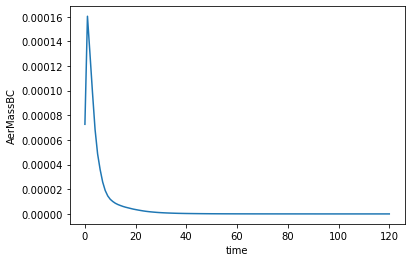

In [19]:
G.plot()

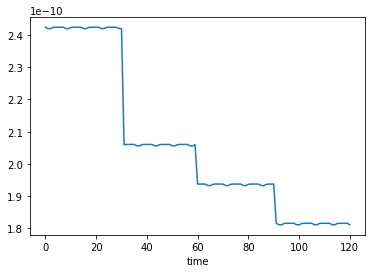

In [20]:
f.plot()

In [21]:
def f_(raw_f, t_p): 
    return raw_f.interp({'time':t_p})

In [22]:
def G_(raw_G, t, t_p):
    'where G(t-t_p) such that t-t_p = s), if s<0, the function goes to 0'
    s = t-t_p
    if t>t_p:
        G = raw_G.interp({'time':s}).values/(dt*f_0.values)
    elif t_p>=t:
        G = 0 #np.nan
        
    return(G)

In [23]:
def G_f_kernel(raw_G, raw_f, t, t_p, dt, f_0):
    'where C(t) = int[G(t-t_p)f(t_p)]dt and t_p is the midpoint of the integral (eg: if integrating from 2020-2030, it is dt/2 away from 2020)'
    return(G_(raw_G, t, t_p)*f_(raw_f, t_p).values*dt)
#two dimensions 

In [24]:
Ndt = 45
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)



In [25]:
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)

for i in np.arange(0, len(t_range)):
    for t in t_range:
        C_df[i].loc[t] = G_f_kernel(G, f, t, t_range[i], dt, f_0)
        


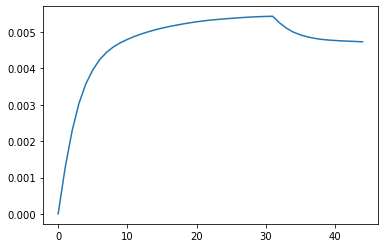

In [26]:
plt.plot(C_df.sum(axis = 1));
#plt.ylim(0,1.2e-9)

C_df =C_df.sum(axis = 0)

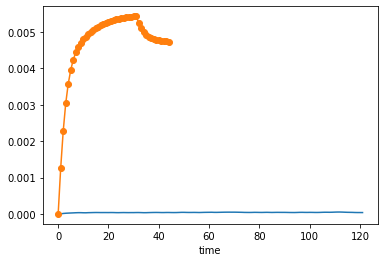

In [27]:
(ds_conc2x['AerMassBC'].weighted(ds_conc2x['AREA']*ds_conc2x['altitude']).mean(dim = ['lat','lon','lev']) - 
 ds_base['AerMassBC'].weighted(ds_base['AREA']*ds_conc2x['altitude']).mean(dim = ['lat','lon','lev'])).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
((C_df.sum(axis = 1)).to_xarray().rename({'index':'time'})).plot(marker = 'o')
#plt.plot(C_df/dt/f_0.values)
#plt.xlim(30,50)
#plt.ylim(1.1,1.5)

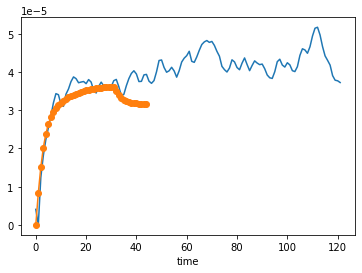

In [30]:
(ds_conc2x['AerMassBC'].weighted(ds_conc2x['AREA']*ds_conc2x['altitude']).mean(dim = ['lat','lon','lev']) - 
 ds_base['AerMassBC'].weighted(ds_base['AREA']*ds_conc2x['altitude']).mean(dim = ['lat','lon','lev'])).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
((C_df.sum(axis = 1)).to_xarray().rename({'index':'time'})/150).plot(marker = 'o')
#plt.plot(C_df/dt/f_0.values)
#plt.xlim(30,50)
#plt.ylim(1.1,1.5)

In [79]:
### other ways of doing f and G

#US ONLY lat, lon, lev average

f = ((ds_emisbase_US['EmisBCPO_Total'].weighted(ds_emisbase_US['AREA'].fillna(0)*ds_emisbase_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])+
     ds_emisbase_US['EmisBCPI_Total'].weighted(ds_emisbase_US['AREA'].fillna(0).fillna(0)*ds_emisbase_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])))
G = (ds_delta_US['AerMassBC'].weighted(ds_delta_US['AREA'].fillna(0)*ds_delta['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])-
     ds_base_US['AerMassBC'].weighted(ds_base_US['AREA'].fillna(0)*ds_base['altitude'].fillna(0)).mean(dim = ['lat','lon','lev']))

f_0 = ((ds_emispulse_US['EmisBCPO_Total'].fillna(0).weighted(ds_emispulse_US['AREA'].fillna(0)*ds_emispulse_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])
        +ds_emispulse_US['EmisBCPI_Total']).weighted(ds_emispulse_US['AREA'].fillna(0)*ds_emispulse_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])- 
    (ds_emisbase_US['EmisBCPO_Total'].weighted(ds_emisbase_US['AREA'].fillna(0)*ds_emisbase_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev'])
     +ds_emisbase_US['EmisBCPI_Total'].weighted(ds_emisbase_US['AREA'].fillna(0)*ds_emisbase_US['altitude'].fillna(0)).mean(dim = ['lat','lon','lev']))).isel(time = 0)

print(f_0.values)

#lat, lon average, first level

f = ((ds_emisbase['EmisBCPO_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])+
     ds_emisbase['EmisBCPI_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])).isel(lev = 0))
G = (ds_delta['AerMassBC'].weighted(ds_delta['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])-
     ds_base['AerMassBC'].weighted(ds_base['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])).isel(lev = 0)

f_0 = ((ds_emispulse['EmisBCPO_Total'].weighted(ds_emispulse['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])
        +ds_emispulse['EmisBCPI_Total']).weighted(ds_emispulse['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])- 
    (ds_emisbase['EmisBCPO_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon'])
     +ds_emisbase['EmisBCPI_Total'].weighted(ds_emisbase['AREA']*ds_emisbase['altitude']).mean(dim = ['lat','lon']))).isel(lev = 0, time = 0)

print(f_0.values)